Fluorescent Powder 
====================================================

### Authors: MFK, MLG, YL, AMW

We try to fit the recurrence relationship to the data


In [1]:
# install if not done yet
#!pip install pyabc --quiet

In [2]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

import pyabc as pyabc
from pyabc import ABCSMC, RV, Distribution, LocalTransition, MedianEpsilon, QuantileEpsilon, AdaptivePNormDistance
from pyabc.visualization import plot_data_callback, plot_kde_2d

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "yi_data.db")

Data
----

We use a data set which consists of a vector of n contact points $n$
and a measurement vector $Y$.  


and the measurement data

In [3]:
data = pd.read_csv('../data/Yi.data.longformat.20191121_censoring_handled.csv', sep=',',header=0)

# create RelavitiveIntD column by dividing RawIntD by the PowderArea column
data['RelIntD'] = data['RawIntD'] / data['PowderArea']

#subset data to filter Surface == Plastic & Gloves == Y, and then take the mean and std of the concentration for each ContactNumber
measurement_data = data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RelIntD'].mean()
# normalise measurement_data bewteen 0 and 1
#measurement_data = (measurement_data - measurement_data.min()) / (measurement_data.max() - measurement_data.min())
#measurement_data = measurement_data / measurement_data.max()

s = data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RawIntD'].std()
measurement_data

ContactNumber
1    135098.530510
2    123526.216716
3    128572.376504
4    121197.938832
5    109294.814118
Name: RelIntD, dtype: float64

## Headers of the Data

In [5]:
data.describe()

,RawIntD,LoadingWeight,ContactNumber,ID,PowderArea,RelIntD
count,2.520000e+03,2514.000000,2520.000000,2520.000000,2520.000000,2.520000e+03
mean,6.227286e+06,102.394321,3.000000,43.047619,50.010102,1.318763e+05
std,4.313066e+06,80.608008,1.414494,24.947219,26.591880,1.019275e+05
min,6.997700e+04,0.352000,1.000000,1.000000,0.881000,6.916033e+03
25%,3.368425e+06,36.981625,2.000000,21.750000,30.255250,8.990277e+04
50%,5.265410e+06,81.746800,3.000000,42.500000,46.708500,1.025679e+05
75%,7.908371e+06,154.166500,4.000000,65.250000,65.610500,1.904805e+05
max,3.451602e+07,299.172773,5.000000,86.000000,174.678000,4.091358e+06


# Visuals

Let's plot the mean and error bars for each of the experimental categories: 
- Gloves (Y/N)
- Surface type (Glass/Plastic/Cloth)


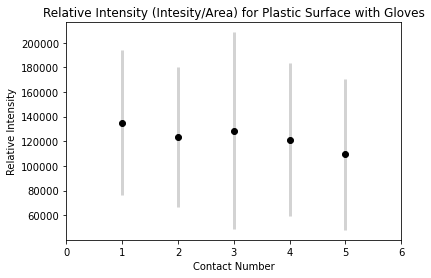

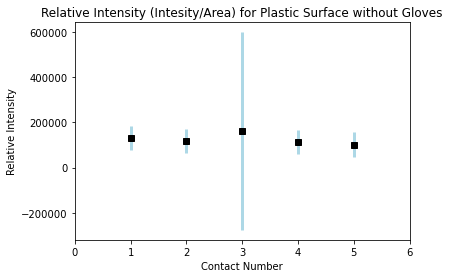

In [4]:
# plot RawIntD for each ContactNumber for Plastic and Y gloves with error bars and N gloves with error bars on the same graph


fig, ax = plt.subplots()
ax.errorbar(data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RelIntD'].mean().index,
            data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RelIntD'].mean(),
            yerr=data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'Y')].groupby('ContactNumber')['RelIntD'].std(),
            fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0)
# add dodge between the two error bars
ax.set_xlim(0, 6)
ax.set_xlabel('Contact Number')
ax.set_ylabel('Relative Intensity')
ax.set_title('Relative Intensity (Intesity/Area) for Plastic Surface with Gloves')
plt.show()

# plot RawIntD for each ContactNumber for Plastic and N gloves with error bars
fig, ax = plt.subplots()
ax.errorbar(data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'N')].groupby('ContactNumber')['RelIntD'].mean().index,
            data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'N')].groupby('ContactNumber')['RelIntD'].mean(),
            yerr=data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'N')].groupby('ContactNumber')['RelIntD'].std(),
            fmt='s', color='black', ecolor='lightblue', elinewidth=3, capsize=0)
# add dodge between the two error bars
ax.set_xlim(0, 6)
ax.set_xlabel('Contact Number')
ax.set_ylabel('Relative Intensity')
ax.set_title('Relative Intensity (Intesity/Area) for Plastic Surface without Gloves')
plt.show()




# RawIntD divided by PowderArea : RelIntD

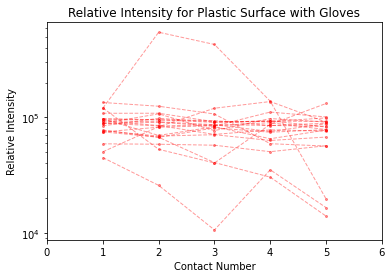

In [5]:
# Plot the RelIntD for each ContactNumber for Plastic and Y gloves for each ID<21 on the same graph
fig, ax = plt.subplots()
for i in range(1, 21):
    ax.plot(data.loc[(data['Surface'] == 'Glass') & (data['Gloves'] == 'Y') & (data['ID'] == i)].groupby('ContactNumber')['RelIntD'].mean().index,
            data.loc[(data['Surface'] == 'Glass') & (data['Gloves'] == 'Y') & (data['ID'] == i)].groupby('ContactNumber')['RelIntD'].mean(),
            marker='o', color='red', linestyle='dashed', linewidth=1, markersize=2,alpha=.4)
    """ax.plot(data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'N') & (data['ID'] == i)].groupby('ContactNumber')['RelIntD'].mean().index,
            data.loc[(data['Surface'] == 'Plastic') & (data['Gloves'] == 'N') & (data['ID'] == i)].groupby('ContactNumber')['RelIntD'].mean(),
            marker='o', color='blue', linestyle='dashed', linewidth=1, markersize=2)"""
# add dodge between the two error bars
ax.set_xlim(0, 6)
ax.set_xlabel('Contact Number')
ax.set_ylabel('Relative Intensity')
ax.set_title('Relative Intensity for Plastic Surface with Gloves')
#log scale y axis
ax.set_yscale('log')
plt.show()


Let's plot some historgrams of the variables.

(0.0, 500000.0)

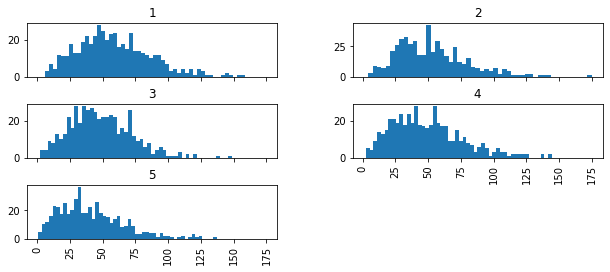

In [8]:
# summarise the data
data.describe()

#create a historgam RelIntD and colour by Gender   
data['PowderArea'].hist(bins=50, by=data['ContactNumber'],sharex=True, sharey=False, figsize=(10,4))
# x-axis limit 0 to 0.5e6
plt.xlim(0, 0.5e6)




as well as the contact points at which to evaluate

In [9]:
measurement_times = np.linspace(1, 5, 5)
measurement_times 

array([1., 2., 3., 4., 5.])

# Estimating the finger area f_a from p_a
We fit a Poisson GLM with variance stabilising link function to the sub-sampled data

,PowderArea,SurfaceArea,LoadingWeight,ID,ContactNumber
count,150.000000,150.00000,150.000000,150.000000,150.000000
mean,54.146427,113.52976,90.859431,15.500000,3.000000
std,22.853791,37.85614,59.193877,8.684438,1.418951
min,8.433000,34.86200,6.009700,1.000000,1.000000
25%,37.587000,85.47325,43.920025,8.000000,2.000000
50%,51.980000,105.97250,80.470900,15.500000,3.000000
75%,65.517500,132.87075,127.486125,23.000000,4.000000
max,129.052000,217.09000,220.000000,30.000000,5.000000


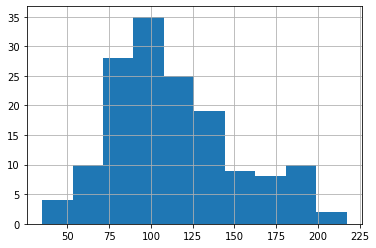

In [9]:
# Import the sub-sampled data from Sheet 2
sub_df = pd.read_csv('../data/30_subsample.csv', sep=',',header=0)
sub_df['SurfaceArea'].hist()
sub_df.describe()

In [14]:
import statsmodels.api as sm

# Add a column of ones to the data to include an intercept term in the model
sub_df['intercept'] = 1

# Fit the model
model = sm.GLM(sub_df['SurfaceArea'], sub_df[['intercept', 'PowderArea']], family=sm.families.InversePower(link=sm.families.links.log))
result = model.fit()

# Print the model summary
print(result.summary())


AttributeError: module 'statsmodels.genmod.families' has no attribute 'InversePower'

Define the analytical recursive model:

- Finger loading after $n$ contacts: $x_n = x_{n-1} (1 - \lambda)$ 
- Surface loading after $n$ contacst $y_n = \lambda  x_{n-1} A $

In [30]:
def predict_luminescence(lambda_, x_prev, A):
    """
    Predict the luminescence on the surface after a contact.

    Parameters
    ----------
    lambda_ : float
        Transfer efficiency.
    x_prev : float  
        Amount of powder on the finger before the contact.
    A : float
        Surface area in contact with the surface.
    
    Returns
    -------
    y : float
        Predicted luminescence on the surface after the contact.
    x_next : float 
        Amount of powder on the finger after the contact.
    """
    y = lambda_ * x_prev * A
    x_next = x_prev * (1 - lambda_)
    return y, x_next




def model(param):
    """
    Model function for the piecewise solution.
    
    Parameters
    ----------
    param : tuple
        Tuple containing the values of the parameters A, x_init and lambda_.
        
    Returns
    -------
    C : array-like
        Array of luminescence values at the given contact.
    """
    x_prev = param['x_prev'] # initial amount of powder on the finger 
    A = param['A'] # finger area
    lambda_ = param['lambda_'] # transfer efficiency

    #t = measurement_times
    # Initialize empty array for concentration values
    #C = np.zeros_like(t)

    # Initialize the amount of powder on the finger before the first contact
    #x_prev = 100

    # Initialize empty array for concentration values
    C = [] #np.zeros_like(6)

    # Set the number of contacts
    num_contacts = 5

    # Iterate over the range of contacts
    for n in range(num_contacts):
        # Calculate the predicted luminescence on the surface and the amount of powder on the finger after the current contact
        y, x_prev = predict_luminescence(lambda_, x_prev, A)

        # Append the predicted luminescence to the list
        C.append(y)


    # Add noise to the simulated data
    sigma = 1E4
    C = np.array(C) + np.random.normal(0, sigma, size=len(C))
    

    return {"Concentration":C}




#model({"E":0.0001,"k":0.003851195,"lambda_":0.0001})['Concentration'].shape

#distance({"Concentration":measurement_data}, model({"E":10,"k":0.003851195,"lambda_":1.11}))


In [11]:
def standardize(x, mu, sigma):
  x_standardized = (x - mu) / sigma
  return x_standardized

def model(param):
    # Unpack the parameters from the tuple
    lambdas, x_0, surface_areas = param
    mu_lambda = 0.1
    sigma_lambda = 0.1
    mu_x_0 = 1_000_000_000
    sigma_x_0 = 1_000_000
    mu_A = 2.2
    sigma_A = 1

    # Standardize the parameters
    lambdas_standardized = [standardize(lambda_, mu_lambda, sigma_lambda) for lambda_ in lambdas]
    x_0_standardized = standardize(x_0, mu_x_0, sigma_x_0)
    surface_areas_standardized = [standardize(A, mu_A, sigma_A) for A in surface_areas]

    n_contacts = len(lambdas_standardized)
    x_prev = x_0_standardized
    luminescences = []
    for i in range(n_contacts):
        y, x_prev = predict_luminescence(lambdas_standardized[i], x_prev, surface_areas_standardized[i])
        luminescences.append(y)
    return luminescences



Define the true parameters (chosen by eye using a manual piece-wise curve fitting of the VMN_ad_08 file.)

In [31]:
A_true, x_prev_true, lambda_true = np.array([2.5, 880_980, 0.066])
#t1 = measurement_times[15:44]
#t1-np.min(t1)
model({"A": A_true, "x_prev": x_prev_true, "lambda_":lambda_true})

{'Concentration': array([139722.33965723, 136385.68268692, 128339.57294498, 126366.43942985,
        102595.40583778])}

Solve the model for the true parameter values and visualise the results

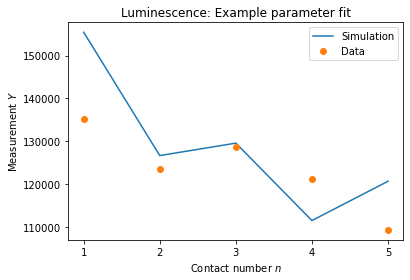

In [33]:
param = {'lambda_':lambda_true, 'x_prev':x_prev_true, 'A':A_true}
true_trajectory = model(param)["Concentration"]
plt.plot(measurement_times,true_trajectory, color="C0", label='Simulation')
#plt.plot(measurement_times, measurement_data, color="C1", label='Data')
#add error bars
#plt.errorbar(measurement_times, measurement_data, yerr=s, fmt='o', color="C1",label='Data')
plt.plot(measurement_times, measurement_data, 'o', color="C1",label='Data')
# plot on log scale
#plt.yscale('log')
plt.xlabel('Contact number $n$')
# make xticks integers
plt.xticks(np.arange(1, 6, 1.0))
plt.ylabel('Measurement $Y$')
plt.title('Luminescence: Example parameter fit')
plt.legend()
plt.show()

#np.array(model({'E':3.851195,'k':0.003,'lambda_':1.174})).max()

In [ ]:
def distance(simulation, data):
    return np.absolute(data["Concentration"] - simulation["Concentration"]).sum()

Define the prior for $A$, $x_prev$, and $\lambda$

In [42]:
parameter_prior = Distribution(
    A=RV("uniform", 1.5, 3.5), x_prev=RV("uniform", 500_000, 1_750_000), lambda_=RV("uniform", 0, 0.3)
)
parameter_prior.get_parameter_names()

['A', 'lambda_', 'x_prev']

In [43]:
from pyabc.populationstrategy import AdaptivePopulationSize

distance_adaptive = pyabc.AdaptivePNormDistance(
    p=1,
    scale_function=pyabc.distance.pcmad,
)

abc = ABCSMC(
    models=model,
    parameter_priors=parameter_prior,
    distance_function=distance_adaptive,
    population_size=1000,#AdaptivePopulationSize(500, 0.15),
    acceptor=pyabc.UniformAcceptor(use_complete_history=True),
    #eps=QuantileEpsilon(alpha=0.4)
    #transitions=LocalTransition(k_fraction=0.3),
    # eps=MedianEpsilon(500, median_multiplier=0.7),
)

ABC.Sampler INFO: Parallelize sampling on 8 processes.


In [44]:
abc.new(db_path, {"Concentration": np.array(measurement_data)})

ABC.History INFO: Start <ABCSMC id=4, start_time=2023-01-02 21:50:52>


In [45]:
h = abc.run(max_nr_populations=15) #

ABC INFO: Calibration sample t = -1.
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 2.77624586e+00.
ABC INFO: Accepted: 1000 / 2059 = 4.8567e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.12951743e+00.
ABC INFO: Accepted: 1000 / 2001 = 4.9975e-01, ESS: 8.4225e+02.
ABC INFO: t: 2, eps: 1.34777992e+00.
ABC INFO: Accepted: 1000 / 2286 = 4.3745e-01, ESS: 9.4826e+02.
ABC INFO: t: 3, eps: 1.19141778e+00.
ABC INFO: Accepted: 1000 / 2421 = 4.1305e-01, ESS: 9.5251e+02.
ABC INFO: t: 4, eps: 1.18098504e+00.
ABC INFO: Accepted: 1000 / 2758 = 3.6258e-01, ESS: 9.5125e+02.
ABC INFO: t: 5, eps: 1.38217359e+00.
ABC INFO: Accepted: 1000 / 3281 = 3.0479e-01, ESS: 9.4784e+02.
ABC INFO: t: 6, eps: 1.54233835e+00.
ABC INFO: Accepted: 1000 / 5385 = 1.8570e-01, ESS: 9.4587e+02.
ABC INFO: t: 7, eps: 1.42691271e+00.
ABC INFO: Accepted: 1000 / 9911 = 1.0090e-01, ESS: 9.1188e+02.
ABC INFO: t: 8, eps: 1.30190519e+00.
ABC INFO: Accepted: 1000 / 17061 = 5.8613e-02, ESS: 9.2099e+02.
A

Visualization of the probability density functions for $A$, $x_{prev}$ and $\lambda$

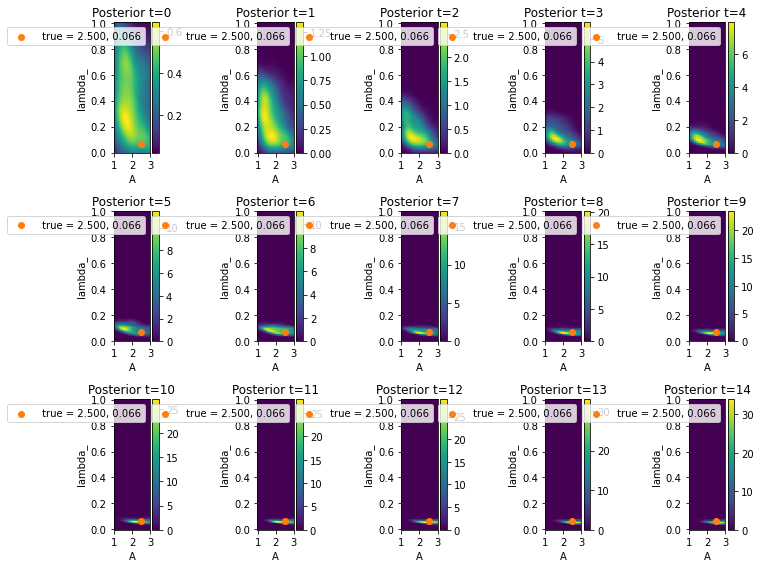

In [41]:
fig = plt.figure(figsize=(10, 8))
for t in range(h.max_t + 1):
    ax = fig.add_subplot(3, int(np.ceil(h.max_t / 3)), t + 1)

    ax = plot_kde_2d(
        *h.get_distribution(m=0, t=t),
        "A",
        "lambda_",
        xmin=1,
        xmax=3,
        numx=200,
        ymin=0,
        ymax=1,
        numy=200,
        ax=ax,
    )
    ax.scatter(
        [A_true],
        [lambda_true],
        color="C1",
        label=r' true = {:.3f}, {:.3f}'.format(
            A_true, lambda_true
        ),
    )
    ax.set_title(f"Posterior t={t}")

    ax.legend()
fig.tight_layout()

Plot marginal histograms of the posterior distributions of the three parameters

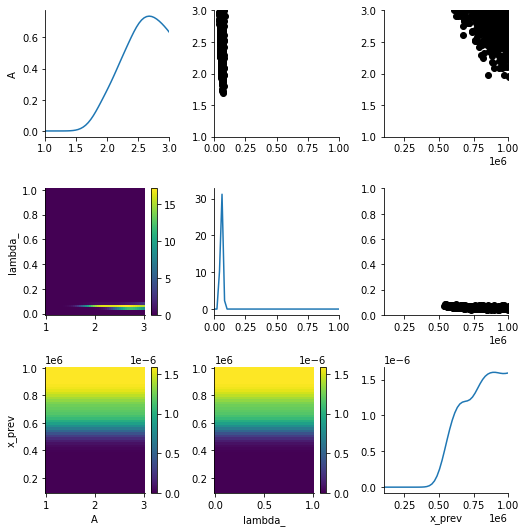

In [38]:
from pyabc.visualization import plot_kde_matrix

limits = dict(A=(1, 3), x_prev=(1E5, 1E6), lambda_=(0, 1))
df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

We can also plot the simulated trajectories:

<Figure size 720x576 with 0 Axes>

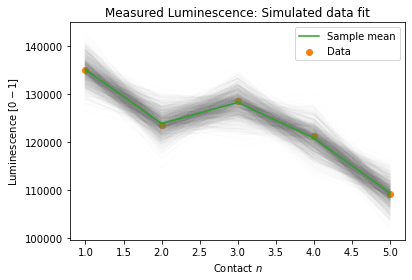

In [47]:
fig = plt.figure(figsize=(10, 8))
_, ax = plt.subplots()


def plot_data(sum_stat, weight, ax, **kwargs):
    """Plot a single trajectory"""
    ax.plot(measurement_times, sum_stat['Concentration'], color='grey', alpha=0.01)


def plot_mean(sum_stats, weights, ax, **kwargs):
    """Plot mean over all samples"""
    weights = np.array(weights)
    weights /= weights.sum()
    data = np.array([sum_stat['Concentration'] for sum_stat in sum_stats])
    mean = (data * weights.reshape((-1, 1))).sum(axis=0)
    ax.plot(measurement_times, mean, color='C2', label='Sample mean')


ax = plot_data_callback(h, plot_data, plot_mean, ax=ax)

#plt.plot(measurement_times,true_trajectory, color="C0", label='Initial guess')
plt.scatter(measurement_times, measurement_data, color="C1", label='Data')
plt.xlabel('Contact $n$')
plt.ylabel('Luminescence $[0-1]$')
plt.title('Measured Luminescence: Simulated data fit')
plt.legend()
plt.show()

#save image
fig.savefig('luminescence_fit.png', dpi=300)


Summary table of parameters

In [40]:
# Create a summary table of parameter values
df, w = h.get_distribution(m=0, t=h.max_t)
df['w'] = w
df = df.sort_values('w', ascending=True)
df = df.reset_index(drop=True)
df = df.round(3)
df.describe()


name,A,lambda_,x_prev,w
count,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,2.797405,0.055623,9.232523e+05,0.001075
std,0.474682,0.008428,1.696715e+05,0.000278
min,1.694000,0.036000,5.338059e+05,0.001000
25%,2.466750,0.049000,7.991989e+05,0.001000
50%,2.759500,0.055000,9.306586e+05,0.001000
75%,3.107250,0.060250,1.055217e+06,0.001000
max,4.318000,0.083000,1.249985e+06,0.003000


## Mixed effects model

In [ ]:
#%pip install statsmodels
import statsmodels.formula.api as smf

# Fit a mixed-effects model to the data
model = smf.mixedlm('RawIntD ~ ContactNumber + PowderArea + Gloves + Surface', data, groups='ID')
result = model.fit()

# Print the summary of the model fit
print(result.summary())


                        Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        RawIntD           
No. Observations:         2520           Method:                    REML              
No. Groups:               84             Scale:                     2196824937021.2490
Min. group size:          30             Log-Likelihood:            -39505.7592       
Max. group size:          30             Converged:                 Yes               
Mean group size:          30.0                                                        
--------------------------------------------------------------------------------------
                         Coef.        Std.Err.     z    P>|z|    [0.025       0.975]  
--------------------------------------------------------------------------------------
Intercept                1203432.562 328624.226   3.662 0.000   559340.915 1847524.209
Gloves[T.Y]              -312752.183  60151.684  -5.199 0.000  -4306